In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def read_files(path):
    file_contents = list()
    filenames = os.listdir(path)
    
    for i in range(len(filenames)):
        with open(path+filenames[i]) as f:
            file_contents.append(f.read())
    
    return file_contents

In [3]:
class_0 = read_files('20news-18828/comp.graphics/')
class_1 = read_files('20news-18828/rec.motorcycles/')

In [4]:
labels = ['comp.graphics', 'rec.motorcycles']

In [5]:
all_texts = np.append(class_0, class_1)

In [6]:
stop_words = set(stopwords.words('english'))
def clean(text):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('\S*@\S*\s?', '', text)
    text = re.sub('https?://[A-Za-z0-9]','',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    word_tokens = word_tokenize(text)    
    filtered_sentence = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            filtered_sentence.append(word_token)
    
    text = (' '.join(filtered_sentence))
    return text

In [7]:
all_cleaned_texts = np.array([clean(text) for text in all_texts])

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

In [9]:
len(tokenizer.word_index)

20200

In [10]:
all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

<ipython-input-10-f9ff0a1669d7>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_encoded_texts = np.array(all_encoded_texts)


In [11]:
all_encoded_texts = sequence.pad_sequences(all_encoded_texts, maxlen=500)

In [12]:
labels_0 = np.array([0] * len(class_0))
labels_1 = np.array([1] * len(class_1))

In [13]:
all_labels = np.append(labels_0, labels_1)

In [14]:
all_labels = all_labels[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(all_labels)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, all_labels, test_size=0.2, random_state=11)

In [54]:
model = Sequential()
model.add(Embedding(input_dim=20201, output_dim=32, input_length=500))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))

In [55]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [56]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
25/25 [==============================] - 24s 955ms/step - loss: 0.6704 - accuracy: 0.5719 - val_loss: 0.5943 - val_accuracy: 0.6193
Epoch 2/15
25/25 [==============================] - 22s 887ms/step - loss: 0.3897 - accuracy: 0.8728 - val_loss: 0.2261 - val_accuracy: 0.9670
Epoch 3/15
25/25 [==============================] - 23s 902ms/step - loss: 0.9051 - accuracy: 0.6317 - val_loss: 0.6937 - val_accuracy: 0.4645
Epoch 4/15
25/25 [==============================] - 23s 901ms/step - loss: 0.6785 - accuracy: 0.5324 - val_loss: 0.6892 - val_accuracy: 0.4645
Epoch 5/15
25/25 [==============================] - 22s 896ms/step - loss: 0.6782 - accuracy: 0.5324 - val_loss: 0.6887 - val_accuracy: 0.4645
Epoch 6/15
25/25 [==============================] - 22s 897ms/step - loss: 0.6748 - accuracy: 0.5324 - val_loss: 0.6869 - val_accuracy: 0.4645
Epoch 7/15
25/25 [==============================] - 22s 881ms/step - loss: 0.6617 - accuracy: 0.5324 - val_loss: 0.6875 - val_accuracy: 0.4645

In [57]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

In [58]:
y_test_evaluate = np.argmax(y_test, axis=1)

In [59]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 98.477155


In [60]:
cm = confusion_matrix(y_test_evaluate, predictions)

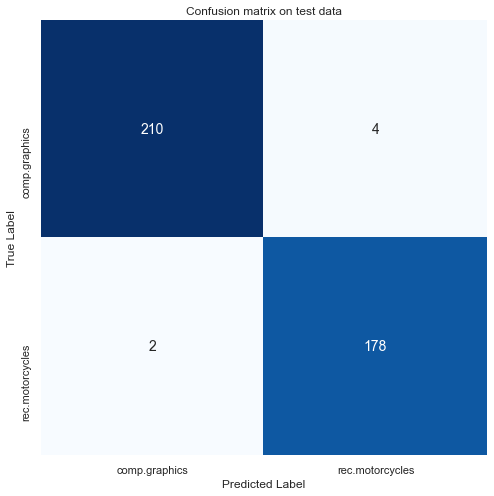

In [61]:
plt.figure(figsize=(8,8))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()